# Estimating Home Values: Final
## Goals
Use squarefootage, bedroom count, and bathroom count to predict the tax value of a single unit property sold during the "hot" months of May and June 2017 in Los Angeles, CA  

We want to be able to predict :  
- Key Drivers of market value for single unit properties 
- Distribution of tax rates for each county

## Overview of Data Science Pipeline Within This Notebook

### 1. Acquire
The get_mvp_home_data() function within the Acquire module:
- Connects to the SQL database with env.py login credentials
- Checks if the data is already saved to csv file (has the function been run in the current working directory?)
- If no .csv file
    - Connects to the Zillow Database
    - Reads a sql query that selects the 4 features of single unit properties during May and June
    - Saves to a csv, and returns the df
- If .csv file
    - Returns df from the csv
    
After acquiring the data, we can do univariate exploration:
- Describe the data
- Plot single variable histograms

### 2. Prepare
Within the Prepare module, the data is prepped by:
- Renaming columns
- Dropping uneeded id column
- Removing outliers using z-score to determine
- Splitting into train, validate, test
- Scaling the data

### 3. Explore
- Once data is split, we can perform bivariate analysis on train
- Determine what features influence tax value more
    - Hypothesis testing
    - Plotting correlation
    - Plotting bivariate analysis

### 4. Modeling
- Create a baseline prediction of tax value
- Create models
    - Fit models on train
        - Use LinearRegression, LassoLars, Polynomial
    - Ensure models not overfit, testing top 3 models on validate
    - Simulate best model being run on future unseen data, test on test df

### 5. Conclusions
Conclude which model preforms best, which features have the highest influence on tax value, and what to do with this information

In [1]:
# Set up the notebook imports
# Import modules
import Acquire
import Prepare

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Modeling Imports
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

# Modeling Metrics
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Imports Completed.')

Imports Completed.


# 1. Acquire

In [2]:
df = Prepare.prep_zillow_df(Prepare.get_mvp_home_data())

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18490 entries, 0 to 19148
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sqft            18490 non-null  float64
 1   bedroom_count   18490 non-null  float64
 2   bathroom_count  18490 non-null  float64
 3   tax_value       18490 non-null  float64
dtypes: float64(4)
memory usage: 722.3 KB


In [4]:
df.describe()

,sqft,bedroom_count,bathroom_count,tax_value
count,18490.00000,18490.000000,18490.000000,1.849000e+04
mean,1794.93629,3.113413,2.284072,4.483963e+05
std,968.72753,1.016633,0.965707,5.490209e+05
min,60.00000,0.000000,0.000000,1.000000e+02
25%,1210.00000,2.000000,2.000000,1.979842e+05
50%,1566.00000,3.000000,2.000000,3.342260e+05
75%,2114.00000,4.000000,3.000000,5.308875e+05
max,26345.00000,10.000000,19.500000,1.717000e+07


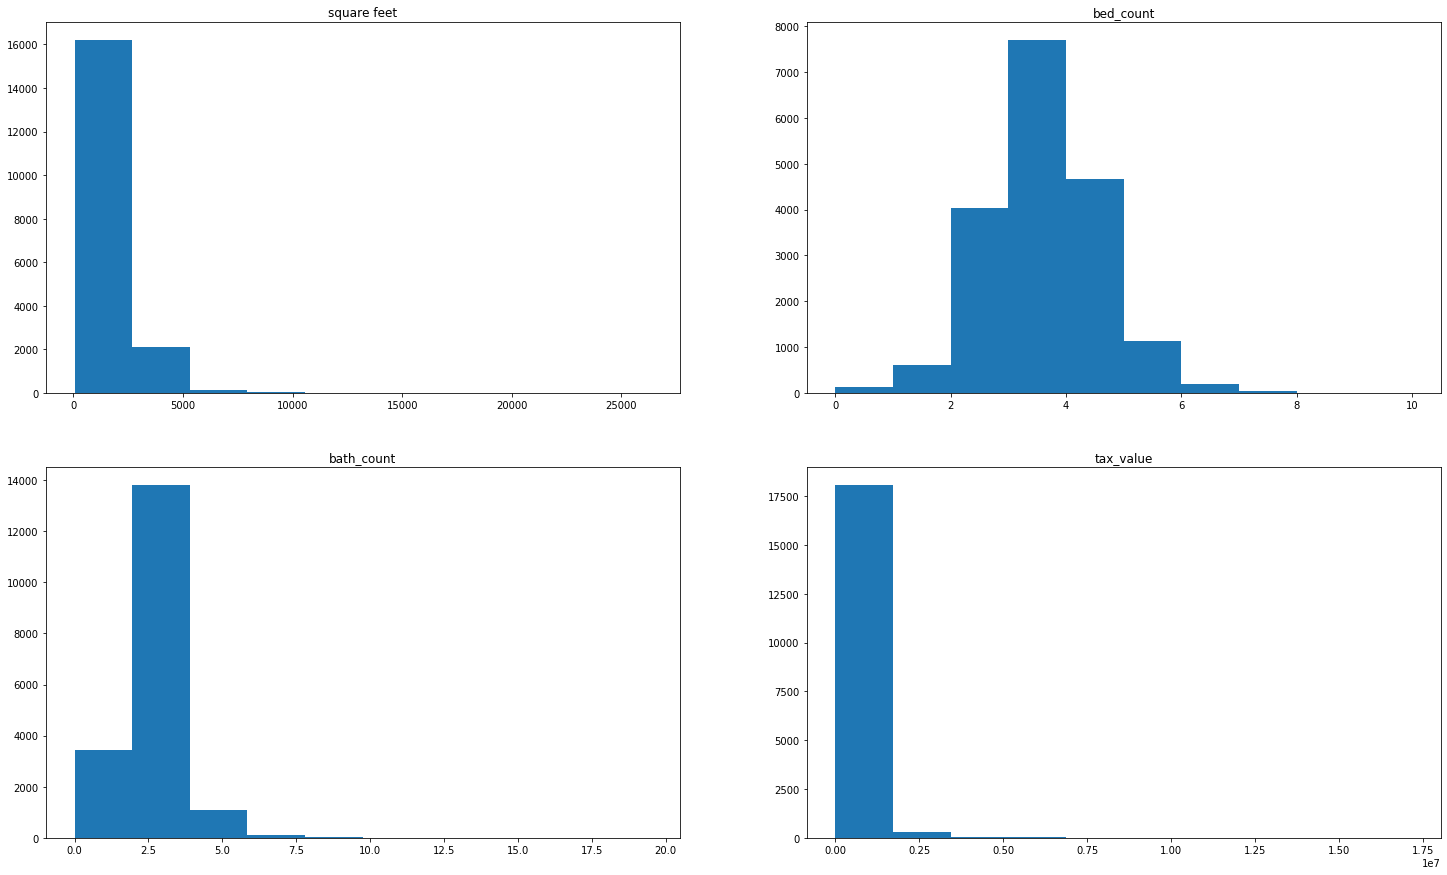

In [5]:
# Construct a figure with subplots of histograms of features

# Sets size, can adjust 
plt.subplots(figsize=(25, 15))

plt.subplot(2,2,1);
line1 = plt.hist(df.sqft)
plt.title('square feet');

plt.subplot(2,2,2);
line2 = plt.hist(df.bedroom_count);
plt.title('bed_count');

plt.subplot(2,2,3);
line3 = plt.hist(df.bathroom_count);
plt.title('bath_count');

plt.subplot(2,2,4);
line3 = plt.hist(df.tax_value);
plt.title('tax_value');

### Takeaways
- Bedroom count is normally distributed
- Outliers are present in all other features

# 2. Prepare

## Removing Outliers

In [6]:
# Calculate z-score for each value in df
z = np.abs(stats.zscore(df))

# create train df without outliers
df_o = df[(z < 3).all(axis=1)]

## Splitting the Data
Within the prepare module, our function splits the data into
- about 70% for train
- about 20% for validate
- exactly 10% for test

In [7]:
train, validate, test = Prepare.train_test_validate(df)

train shape:  (13312, 4) , validate shape:  (3329, 4) , test shape:  (1849, 4)

train percent:  72.0 , validate percent:  18.0 , test percent:  10.0


In [8]:
# take a look at the data
# we have scaled values for our independent features, random sampling of properties seen by index
train.head()

,sqft,bedroom_count,bathroom_count,tax_value,bath_count_scaled,bed_count_scaled,square_feet_scaled
11548,1414.0,3.0,2.0,156164.0,-0.393602,-0.113343,-0.295933
4070,1541.0,2.0,3.0,245710.0,-0.260492,-1.096286,0.753889
4206,1672.0,3.0,2.0,85486.0,-0.123189,-0.113343,-0.295933
13273,2555.0,4.0,3.0,587732.0,0.802292,0.869601,0.753889
12135,1040.0,3.0,1.0,403858.0,-0.785595,-0.113343,-1.345755


## Plotting Distribution of Independent Features Before and After Scaling

Text(0.5, 1.0, 'Standard Scaled Bathroom Count')

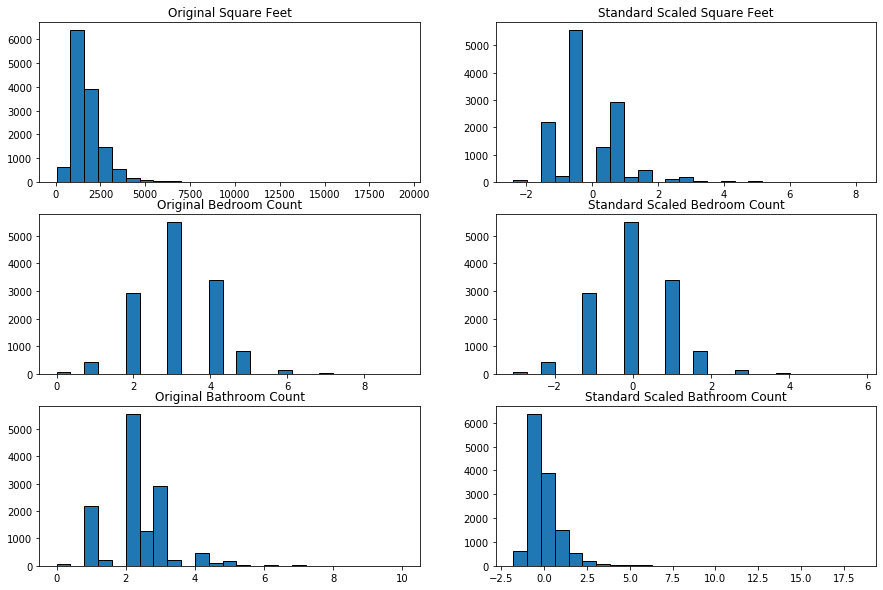

In [9]:
# setting size of the whole figure
plt.figure(figsize=(15, 10))

# Our subplot is a 3 by 2 matrix
# First plot
plt.subplot(321)
plt.hist(train.sqft, bins=25, ec='black')
plt.title('Original Square Feet')

# Second plot
plt.subplot(322)
plt.hist(train.square_feet_scaled, bins=25, ec='black')
plt.title('Standard Scaled Square Feet')

# Third plot
plt.subplot(323)
plt.hist(train.bedroom_count, bins=25, ec='black')
plt.title('Original Bedroom Count')

# Fourth plot
plt.subplot(324)
plt.hist(train.bed_count_scaled, bins=25, ec='black')
plt.title('Standard Scaled Bedroom Count')

# Fifth plot
plt.subplot(325)
plt.hist(train.bathroom_count, bins=25, ec='black')
plt.title('Original Bathroom Count')

# Sixth plot
plt.subplot(326)
plt.hist(train.bath_count_scaled, bins=25, ec='black')
plt.title('Standard Scaled Bathroom Count')

## Takeaways
After prepping, the data:
- Has no outliers
- Is split into train, validate, test
- Is scaled

# 3. Explore

## Visualization of Bivariate Analysis

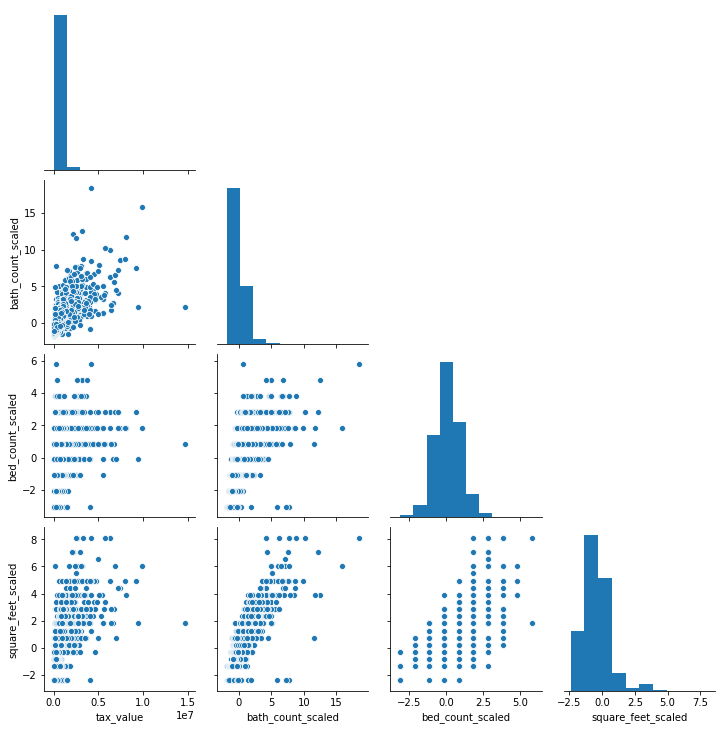

In [10]:
# pairplot of scaled data
sns.pairplot(train.drop(['sqft','bedroom_count','bathroom_count'],axis=1), corner=True)

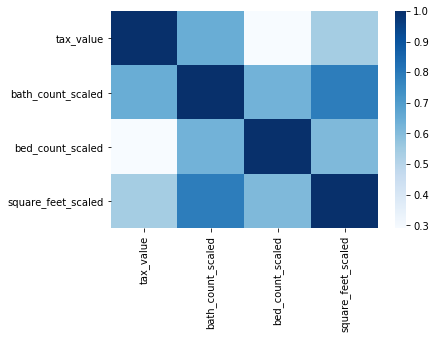

In [11]:
corr = train.drop(['sqft','bedroom_count','bathroom_count'],axis=1).corr()
sns.heatmap(corr, cmap='Blues')

(0, 25)

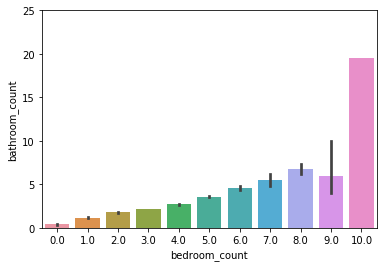

In [12]:
sns.barplot(data=df, x='bedroom_count', y='bathroom_count')
plt.ylim(0,25)

## Hypothesis Testing

### T-Test: Sqft vs Price
Does square footage affect tax value?

In [13]:
train.sqft.mean()

1789.5347806490386

$H_0$: The average price of homes with 5000 sq.ft. or more is equal to the average price of homes with 5000 sq.ft. or less.

$H_A$: Homes with 5000 sq.ft. or more have higher than average tax dollar count.

In [14]:
df_less_than_5000 = train[train.sqft >= 5000]
df_greater_than_5000 = train[train.sqft > 5000]

a = df_less_than_5000.tax_value.mean()

b = df_greater_than_5000.tax_value.mean()

t, p = stats.ttest_ind(df_greater_than_5000.tax_value,
                df_less_than_5000.tax_value)

if p > a:
    print('We Fail to Reject the Null Hypothesis')
else:
    print('We Reject the Null Hypothesis')

We Reject the Null Hypothesis


### T-Test: Bathroom count vs. Price
Does bathroom count affect tax value?

In [15]:
train.bathroom_count.mean()

2.2818885216346154

$H_0$: Average price of homes with more than two bathrooms is equal to the average price of homes with less than two bathrooms.

$H_A$: Homes with more than two bathrooms have higher than average tax dollar count.

In [16]:
df_less_than_2_bath = train[train.bathroom_count >= 2]
df_greater_than_2_bath = train[train.bathroom_count > 2]

a = df_less_than_2_bath.tax_value.mean()

b = df_greater_than_2_bath.tax_value.mean()

t, p = stats.ttest_ind(df_greater_than_2_bath.tax_value,
                df_less_than_2_bath.tax_value)

if p > a:
    print('We Fail to Reject the Null Hypothesis')
else:
    print('We Reject the Null Hypothesis')

We Reject the Null Hypothesis


### Correlation Test: Sqft vs. Price

$H0$: There is no relationship between total house square feet and tax value

$H1$: There is a relationship between total house square feet and tax value

In [17]:
confidence_interval = 0.95
alpha = 1 - confidence_interval 
t, p = stats.pearsonr(train.sqft, train.tax_value)

corr, p = stats.pearsonr(train.sqft, train.tax_value)
print(corr, p)

if p > a:
    print('We Fail to Reject the Null Hypothesis')
else:
    print('We Reject the Null Hypothesis')

0.648899063193856 0.0
We Reject the Null Hypothesis


## Takeaways
- <b>T-test:</b>
    - Homes with 5000 sq.ft. or more have higher than average tax dollar count.  
        - The average price of homes with 5000 sq.ft. or more is <b>different</b> to the average price of homes with 5000 sq.ft. or less.

    - Homes with more than two bathrooms have higher than average tax dollar count.  
        - The average price of homes with more than two bathrooms is <b>different</b> than the average prices of homes with two or more bathrooms.   
        
        
    
- <b>Correlation test:</b>
    - There is a relationship between total house square feet and tax value  

# 4. Modeling

## Split Into Independent and Dependent Variables

In [18]:
X_train = train.drop(['sqft','bedroom_count','bathroom_count','tax_value'],axis=1)
X_validate = validate.drop(['sqft','bedroom_count','bathroom_count','tax_value'],axis=1)
X_test = test.drop(['sqft','bedroom_count','bathroom_count','tax_value'],axis=1)

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

## Baseline
- How the target variable is distributed will determine the baseline
- Mean, median, or mode of tax value

In [19]:
train.tax_value.describe().apply(lambda x: format(x, 'f'))

count       13312.000000
mean       444924.834660
std        519762.140179
min           100.000000
25%        197272.250000
50%        333976.000000
75%        531322.250000
max      14721125.000000
Name: tax_value, dtype: object

In [20]:
baseline = train.tax_value.mean()

baseline_mse = mean_squared_error(y_train, np.full(y_train.shape, baseline))
baseline_rmse = baseline_mse**1/2

print('The Baseline Mean Squared Error:', round(baseline_mse,2))
print('The Baseline Root Mean Squared Error:', round(baseline_rmse,2))

The Baseline Mean Squared Error: 270132388442.16
The Baseline Root Mean Squared Error: 135066194221.08


## LinearRegression Model

In [21]:
# create the object
lm = LinearRegression(normalize=True)

# fit object to the train data only
lm.fit(X_train, y_train)

# Predict our training observations
lm_pred = lm.predict(X_train)

# evaluate our training predictions
# compute root mean squared error
lm_mse = mean_squared_error(y_train, lm_pred)
lm_rmse = lm_mse**1/2

lm_rmse

74060953151.81381

## LassoLars

In [22]:
# create the object
lars = LassoLars(alpha=0.1)

# fit to the train data only
lars.fit(X_train, y_train)

# predict our training observations
lars_pred = lars.predict(X_train)

# evaluate our training predictions
lars_mse = mean_squared_error(y_train, lars_pred)
lars_rmse = lars_mse**1/2

lars_rmse

74060953561.81708

## Polynomial Model

In [23]:
pf = PolynomialFeatures(degree=3)

# fit and transform the thing
# to get a new set of features..which are the original features sqauared
X_train_cubed = pf.fit_transform(X_train)

# fit the model using our training observations that have been cubed.
# feed that data into our linear model
# make the thing
lm_cubed = LinearRegression()
lm_cubed.fit(X_train_cubed, y_train)

# predict our training observations (the cubed version)
lm_cubed_pred = lm_cubed.predict(X_train_cubed)

# evaluate our predictions on training observations
lm_cubed_mse = mean_squared_error(y_train, lm_cubed_pred)
lm_cubed_rmse = lm_cubed_mse**1/2

lm_cubed_rmse

67274003446.80885

## Takeaways
- The polynomial model performed the best out of the three models
- The models did a bit better than the baseline

# 5. Conclusions

Key Drivers of market value for single unit properties are (listed from highest correlation to lowest):
- Square footage of property
- Bathroom count
- Bedrooms count

<b>Observations:</b>
- Most units are 3 bedrooms/ 2 bath
- Whether a property has a garage, it greatly affects that total square footage
- Three counties were listed in database:
    - Los Angeles County
    - Orange County
    - Ventura County
- Orange County has the highest average tax value for properties
- Los Angeles County has the most amount of properties
